In [7]:
!pip install .

Processing /content
  Preparing metadata (setup.py) ... done
  Created wheel for gated_gelu_cuda: filename=gated_gelu_cuda-0.0.0-cp311-cp311-linux_x86_64.whl size=543689 sha256=8cc63e063d392453ec10de6dd2b856226a740d9ea6751017d49691ea27e6eaf3
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4ttdcil/wheels/01/d1/e4/ca90c6fac4331f6da6de5353843d0b67505c2bbc8768ac296e
Successfully built gated_gelu_cuda


In [9]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import gated_gelu_cuda
import torch.nn.functional as F

In [13]:
def gated_gelu_numpy(x, W, W_g):
    sqrt_2_pi = 0.7978845608
    c = 0.044715

    gelu_input = x * W
    gelu_out = 0.5 * gelu_input * (1.0 + np.tanh(sqrt_2_pi * (gelu_input + c * gelu_input * gelu_input * gelu_input)))

    sigmoid_input = x * W_g
    sigmoid_out = 1.0 / (1.0 + np.exp(-sigmoid_input))

    return gelu_out * sigmoid_out

In [36]:
def gated_gelu_torch(x, W, W_g):
    gelu_out = F.gelu(torch.mul(x, W))
    sigmoid_out = torch.sigmoid(torch.mul(x, W_g))
    return torch.mul(gelu_out, sigmoid_out)

gated_gelu_torch = torch.compile(gated_gelu_torch)

In [37]:
W = 1.5
W_g = 0.8
sizes = [10**3, 10**4, 10**5, 10**6, 10**7]
runs = 10

times_numpy = []
times_torch_cpu = []
times_torch_cuda = []
times_custom_cuda = []

In [41]:
for _ in range(5):
    dummy_tensor = torch.randn(1024, device="cuda")
    _ = gated_gelu_cuda.gated_gelu_cuda(dummy_tensor, W, W_g)
    _ = gated_gelu_torch(dummy_tensor, W, W_g)

In [42]:
for size in sizes:
    print(f"\nTesting size: {size}")

    np_data = np.random.randn(size).astype(np.float32)
    torch_data_cpu = torch.tensor(np_data)
    torch_data_cuda = torch_data_cpu.cuda()

    start = time.perf_counter()
    for _ in range(runs):
        result_numpy = gated_gelu_numpy(np_data, W, W_g)
    numpy_time = (time.perf_counter() - start) / runs
    times_numpy.append(numpy_time)

    start = time.perf_counter()
    for _ in range(runs):
        result_torch_cpu = gated_gelu_torch(torch_data_cpu, W, W_g)
    torch_cpu_time = (time.perf_counter() - start) / runs
    times_torch_cpu.append(torch_cpu_time)

    torch.cuda.synchronize()
    start_event, end_event = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    start_event.record()
    for _ in range(runs):
        result_torch_cuda = gated_gelu_torch(torch_data_cuda, W, W_g)
    end_event.record()

    torch.cuda.synchronize()
    torch_cuda_time = start_event.elapsed_time(end_event) / (runs * 1000)
    times_torch_cuda.append(torch_cuda_time)

    torch.cuda.synchronize()
    start_event, end_event = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    start_event.record()
    for _ in range(runs):
        result_custom_cuda = gated_gelu_cuda.gated_gelu_cuda(torch_data_cuda, W, W_g)
    end_event.record()

    torch.cuda.synchronize()
    custom_cuda_time = start_event.elapsed_time(end_event) / (runs * 1000)
    times_custom_cuda.append(custom_cuda_time)

    print(f"  NumPy time:       {numpy_time:.6f}s")
    print(f"  PyTorch CPU time: {torch_cpu_time:.6f}s")
    print(f"  PyTorch CUDA:     {torch_cuda_time:.6f}s")
    print(f"  Custom CUDA:      {custom_cuda_time:.6f}s")

    if size <= 100000:
        custom_result_cpu = result_custom_cuda.cpu().numpy()
        torch_result_cpu = result_torch_cuda.cpu().numpy()
        max_diff = np.max(np.abs(custom_result_cpu - torch_result_cpu))
        print(f"  Max difference: {max_diff:.8f}")



Testing size: 1000
  NumPy time:       0.000067s
  PyTorch CPU time: 0.000080s
  PyTorch CUDA:     0.000199s
  Custom CUDA:      0.000029s
  Max difference: 0.00038338

Testing size: 10000
  NumPy time:       0.000183s
  PyTorch CPU time: 0.000079s
  PyTorch CUDA:     0.000075s
  Custom CUDA:      0.000022s
  Max difference: 0.00038314

Testing size: 100000
  NumPy time:       0.001769s
  PyTorch CPU time: 0.000336s
  PyTorch CUDA:     0.000111s
  Custom CUDA:      0.000031s
  Max difference: 0.00038338

Testing size: 1000000
  NumPy time:       0.019943s
  PyTorch CPU time: 0.003174s
  PyTorch CUDA:     0.000086s
  Custom CUDA:      0.000073s

Testing size: 10000000
  NumPy time:       0.262692s
  PyTorch CPU time: 0.050996s
  PyTorch CUDA:     0.000386s
  Custom CUDA:      0.000498s


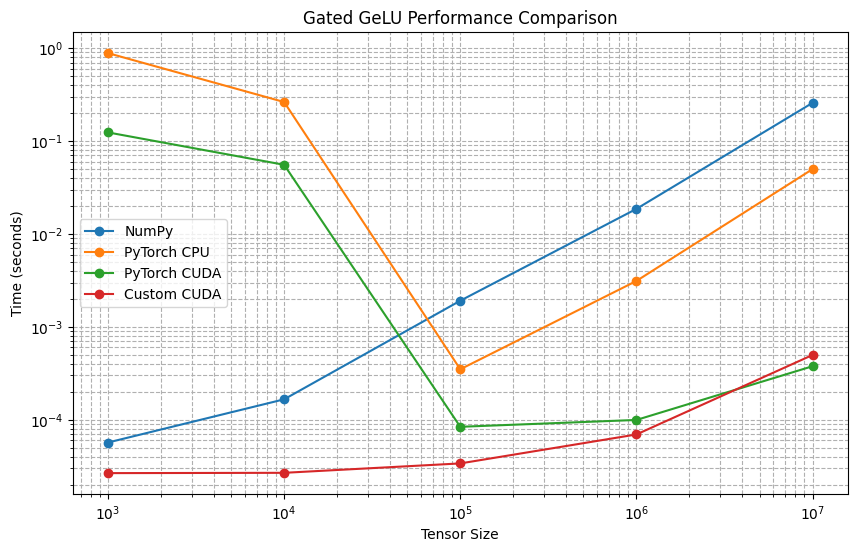

In [39]:
plt.figure(figsize=(10, 6))
plt.loglog(sizes, times_numpy, 'o-', label='NumPy')
plt.loglog(sizes, times_torch_cpu, 'o-', label='PyTorch CPU')
plt.loglog(sizes, times_torch_cuda, 'o-', label='PyTorch CUDA')
plt.loglog(sizes, times_custom_cuda, 'o-', label='Custom CUDA')
plt.xlabel('Tensor Size')
plt.ylabel('Time (seconds)')
plt.title('Gated GeLU Performance Comparison')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('gated_gelu_comparison.png')
plt.show()

In [43]:
largest_idx = -1
print("\nSpeedup for largest size tested:")
print(f"  Custom CUDA vs NumPy:      {times_numpy[largest_idx] / times_custom_cuda[largest_idx]:.2f}x")
print(f"  Custom CUDA vs PyTorch CPU: {times_torch_cpu[largest_idx] / times_custom_cuda[largest_idx]:.2f}x")
print(f"  Custom CUDA vs PyTorch CUDA: {times_torch_cuda[largest_idx] / times_custom_cuda[largest_idx]:.2f}x")


Speedup for largest size tested:
  Custom CUDA vs NumPy:      527.45x
  Custom CUDA vs PyTorch CPU: 102.39x
  Custom CUDA vs PyTorch CUDA: 0.78x
